# 6. 영화리뷰 텍스트 감성분석하기 [프로젝트]
## 6-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [1]:
# 라이브러리 버전 확인
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.

data_loader 안에서는 다음을 수행해야 합니다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터의 중복 제거
    train_data = train_data.dropna(how = 'any') # NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터의 중복 제거
    test_data = test_data.dropna(how = 'any') # NaN 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<UNUSE>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print(get_decoded_sentence(X_train[0], index_to_word)) # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


**데이터셋 내 문장 길이 분포 확인, 적절한 최대 문장 길이 설정**

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


maxlen : 41 로 설정

**keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**

RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적.

"pre" 사용

In [10]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델 구성 및 validation set 구성
**3가지 모델 구성 (conv1d, lstm, GRU)**

In [11]:
from tensorflow.keras.initializers import Constant

vocab_size = 146182    # 어휘 사전의 크기
word_vector_dim = 400  # 워드 벡터의 차원 수 

In [12]:
# Conv1D 모델 구성
conv1d = tf.keras.Sequential()
conv1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen, mask_zero=True))
conv1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d.add(tf.keras.layers.MaxPooling1D(5))
conv1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d.add(tf.keras.layers.GlobalMaxPooling1D())
conv1d.add(tf.keras.layers.Dense(8, activation='relu'))
conv1d.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 400)           58472800  
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            44816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [13]:
# LSTM 모델 구성
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen, mask_zero=True))
lstm.add(tf.keras.layers.LSTM(16))
lstm.add(tf.keras.layers.Dense(16, activation='relu'))
lstm.add(tf.keras.layers.Dense(8, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 400)           58472800  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                26688     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 58,499,905
Trainable params: 58,499,905
Non-trainable params: 0
_________________________________________________________________


In [14]:
# GRU 모델 구성
GRU = tf.keras.Sequential()
GRU.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen, mask_zero=True))
GRU.add(tf.keras.layers.GRU(16))
GRU.add(tf.keras.layers.Dense(16, activation='relu'))
GRU.add(tf.keras.layers.Dense(8, activation='relu'))
GRU.add(tf.keras.layers.Dense(1, activation='sigmoid'))

GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 400)           58472800  
_________________________________________________________________
gru (GRU)                    (None, 16)                20064     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 58,493,281
Trainable params: 58,493,281
Non-trainable params: 0
_________________________________________________________________


**Val set 분리**

In [15]:
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(86182, 41)
(86182,)


### 5) 모델 훈련 개시

In [21]:
conv1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_conv1d = conv1d.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 7s 39ms/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 1.4820 - val_accuracy: 0.8220
Epoch 2/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0067 - accuracy: 0.9972 - val_loss: 1.5830 - val_accuracy: 0.8247
Epoch 3/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0072 - accuracy: 0.9970 - val_loss: 1.5220 - val_accuracy: 0.8238
Epoch 4/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 1.4612 - val_accuracy: 0.8234
Epoch 5/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0089 - accuracy: 0.9965 - val_loss: 1.4476 - val_accuracy: 0.8257
Epoch 6/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0077 - accuracy: 0.9969 - val_loss: 1.5568 - val_accuracy: 0.8253
Epoch 7/20
169/169 [==============================] - 6s 38ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 1.5691 - val_accuracy: 0.8231

In [23]:
results_conv1d = conv1d.evaluate(X_test,  y_test, verbose=2)

print(results_conv1d)

1537/1537 - 3s - loss: 1.8122 - accuracy: 0.8223
[1.8122119903564453, 0.8223447203636169]


In [19]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
169/169 [==============================] - 27s 137ms/step - loss: 0.4323 - accuracy: 0.8062 - val_loss: 0.3526 - val_accuracy: 0.8465
Epoch 2/40
169/169 [==============================] - 22s 133ms/step - loss: 0.3145 - accuracy: 0.8683 - val_loss: 0.3434 - val_accuracy: 0.8518
Epoch 3/40
169/169 [==============================] - 22s 132ms/step - loss: 0.2734 - accuracy: 0.8874 - val_loss: 0.3537 - val_accuracy: 0.8497
Epoch 4/40
169/169 [==============================] - 22s 132ms/step - loss: 0.2355 - accuracy: 0.9036 - val_loss: 0.3571 - val_accuracy: 0.8533
Epoch 5/40
169/169 [==============================] - 22s 131ms/step - loss: 0.2001 - accuracy: 0.9211 - val_loss: 0.3941 - val_accuracy: 0.8485
Epoch 6/40
169/169 [==============================] - 22s 130ms/step - loss: 0.1720 - accuracy: 0.9334 - val_loss: 0.4193 - val_accuracy: 0.8467
Epoch 7/40
169/169 [==============================] - 22s 133ms/step - loss: 0.1482 - accuracy: 0.9440 - val_loss: 0.4629 - val_ac

In [24]:
results_lstm = lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1537/1537 - 12s - loss: 1.6460 - accuracy: 0.8210
[1.6459797620773315, 0.8209817409515381]


In [25]:
GRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_GRU = GRU.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 27s 143ms/step - loss: 0.0611 - accuracy: 0.9793 - val_loss: 0.7790 - val_accuracy: 0.8322
Epoch 2/20
169/169 [==============================] - 23s 138ms/step - loss: 0.0489 - accuracy: 0.9837 - val_loss: 0.8910 - val_accuracy: 0.8290
Epoch 3/20
169/169 [==============================] - 23s 138ms/step - loss: 0.0438 - accuracy: 0.9850 - val_loss: 0.9066 - val_accuracy: 0.8291
Epoch 4/20
169/169 [==============================] - 23s 138ms/step - loss: 0.0422 - accuracy: 0.9854 - val_loss: 0.9581 - val_accuracy: 0.8273
Epoch 5/20
169/169 [==============================] - 23s 138ms/step - loss: 0.0395 - accuracy: 0.9863 - val_loss: 0.9900 - val_accuracy: 0.8236
Epoch 6/20
169/169 [==============================] - 23s 139ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 1.0483 - val_accuracy: 0.8263
Epoch 7/20
169/169 [==============================] - 23s 138ms/step - loss: 0.0344 - accuracy: 0.9877 - val_loss: 1.0972 - val_ac

In [27]:
results_GRU = GRU.evaluate(X_test,  y_test, verbose=2)

print(results_GRU)

1537/1537 - 13s - loss: 1.3870 - accuracy: 0.8240
[1.3869946002960205, 0.8240332007408142]


### 6) Loss, Accuracy 그래프 시각화

In [28]:
import matplotlib.pyplot as plt

In [30]:
history_dict_conv1d = history_conv1d.history
print(history_dict_conv1d.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


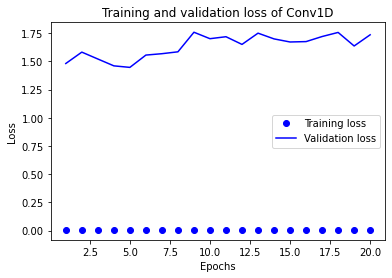

In [31]:
acc = history_dict_conv1d['accuracy']
val_acc = history_dict_conv1d['val_accuracy']
loss = history_dict_conv1d['loss']
val_loss = history_dict_conv1d['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Conv1D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

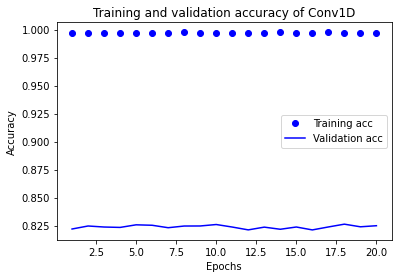

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Conv1D')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
history_dict_lstm = history.history
print(history_dict_lstm.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


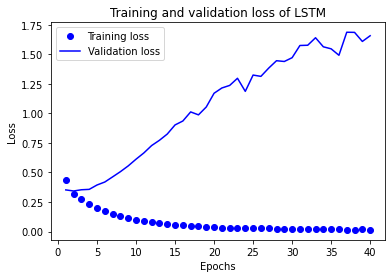

In [36]:
acc = history_dict_lstm['accuracy']
val_acc = history_dict_lstm['val_accuracy']
loss = history_dict_lstm['loss']
val_loss = history_dict_lstm['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

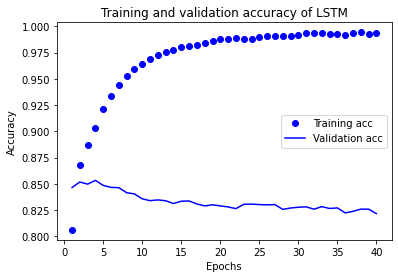

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
history_dict_GRU = history_GRU.history
print(history_dict_GRU.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


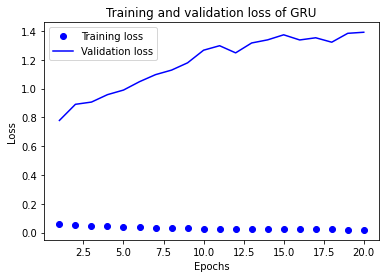

In [40]:
acc = history_dict_GRU['accuracy']
val_acc = history_dict_GRU['val_accuracy']
loss = history_dict_GRU['loss']
val_loss = history_dict_GRU['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

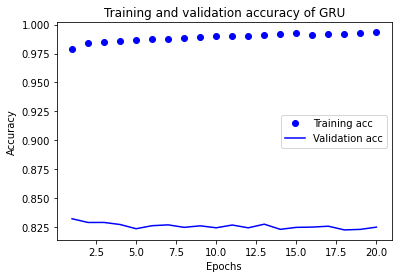

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [42]:
import os

In [44]:
embedding_layer = conv1d.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(146182, 400)


In [52]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
vocab_size = 10000
word_vector_dim = 400

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_1.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = conv1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [54]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['movie']
vector

array([ 2.10452098e-02,  2.17845496e-02,  9.14489999e-02, -1.83550529e-02,
        1.39746249e-01,  7.42215067e-02, -3.34964059e-02, -8.67893174e-02,
       -6.30136533e-03,  3.74231115e-02,  3.19521762e-02,  1.42269984e-01,
       -3.49401422e-02, -1.10084765e-01,  3.51346992e-02, -3.15199122e-02,
        1.75257415e-01, -1.36073917e-01, -2.21619266e-03,  4.97226343e-02,
       -6.63404763e-02,  4.90787858e-03, -9.69258174e-02, -2.00634658e-01,
       -1.88379526e-01, -2.25303713e-02,  1.51243821e-01, -7.78952762e-02,
       -2.75105149e-01,  2.01559719e-02,  3.34334858e-02, -7.06377104e-02,
        1.15636297e-01,  3.75721045e-02,  6.49203826e-03,  5.18325008e-02,
       -5.87675497e-02,  1.07634448e-01, -4.98265028e-02,  8.50838842e-04,
        3.22715081e-02,  3.81977037e-02,  1.73785478e-01, -6.03074208e-03,
       -1.48351314e-02, -9.21036303e-02, -1.29139811e-01, -2.61207353e-02,
        3.73511650e-02,  3.11167408e-02,  9.03944969e-02, -3.01984698e-03,
       -7.59413466e-02, -

In [55]:
# 가장 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("love")

[('챔피언', 0.8849951028823853),
 ('이제서야', 0.8758705258369446),
 ('압도', 0.8698944449424744),
 ('따스', 0.8619720339775085),
 ('고마워요', 0.8602678179740906),
 ('탱고', 0.8591127991676331),
 ('브라질', 0.8578736782073975),
 ('구할', 0.8564664721488953),
 ('and', 0.8499206304550171),
 ('담백', 0.8425288796424866)]

**전혀 상관없는 단어의 유사도만 높은 것을 확인할 수 있다.**

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [59]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word2vec[index_to_word[i]]

TypeError: argument of type 'Word2Vec' is not iterable

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)